# Thermocline spectrum analysis on DAS data
Gets contours on the thermoclines and then plots the spectrum of the DAS data along said thermocline.


In [6]:
# load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import scipy
from skimage import feature
from tqdm import tqdm
from skimage.filters import meijering, sato, frangi, hessian
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from symfit import parameters, variables, sin, cos, Fit
import pickle
import math
from scipy.interpolate import UnivariateSpline
from PyAstronomy import pyaC
import pysindy as ps
import get_temp_amplitude
import sys
sys.path.append("../utils/")
import getDTSdata
import DASfuncs
# import cv2

# matplotlib.use('TkAgg')
# %matplotlib qt
%matplotlib widget

# Load DAS

112 files in directory
Problems with: ../data/DAS/data_1Hz/decimator3_2023-08-15_12.02.22_UTC.h5
Unable to open file (bad object header version number)
2023-08-25 00:13:10 2023-08-29 14:25:56
(396767, 69)


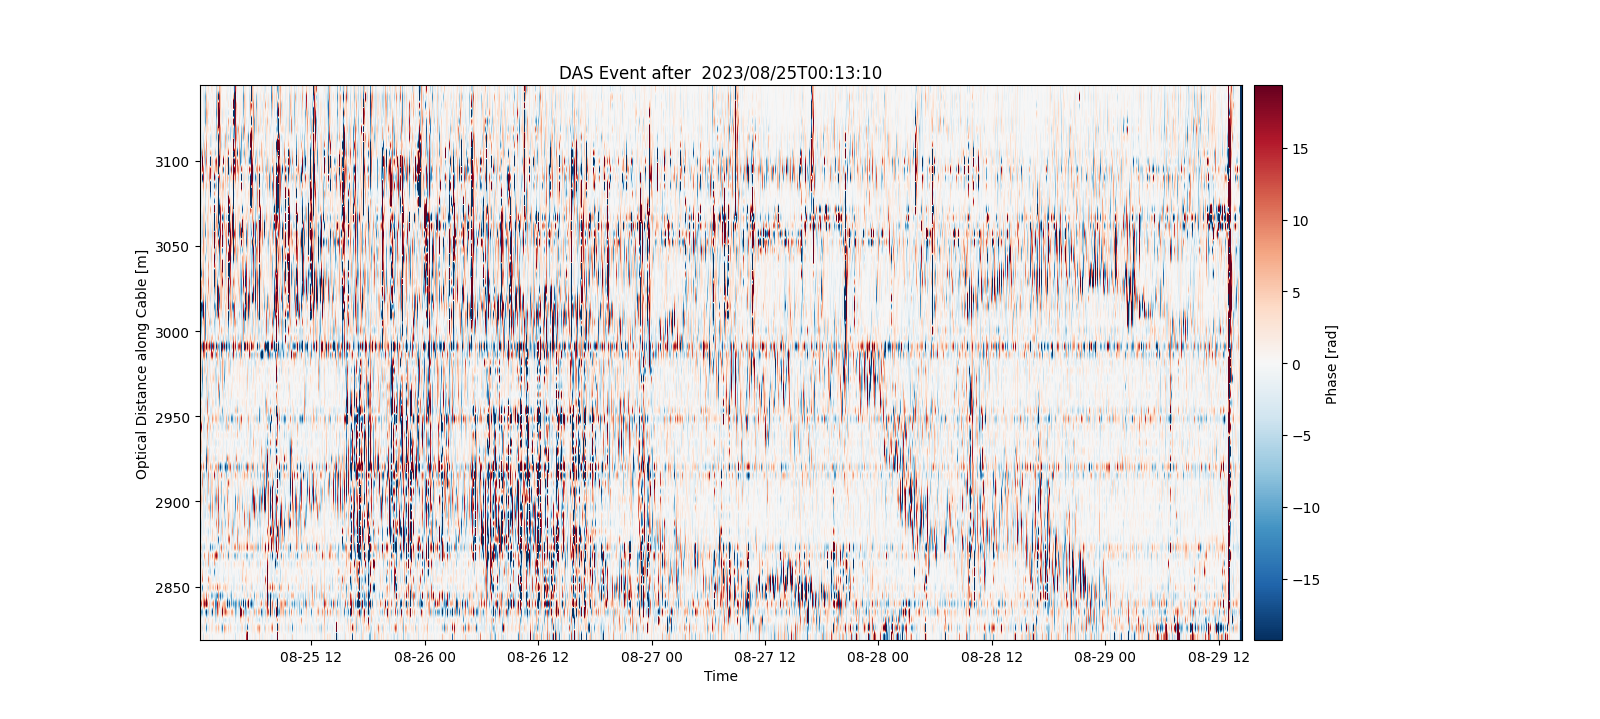

In [9]:
dts_time, dts_dist, dts_data = getDTSdata.getDTSdata()
plt.ion()
# get files
t_start = datetime.datetime(2023,8,25)
t_end = datetime.datetime(2023,8,30)
path = '../data/DAS/data_1Hz'
files = DASfuncs.get_Onyx_h5(path, t_start, t_end)
print('{} files in directory'.format(len(files)))

# read the data
time_read, data_read, attrs_read = DASfuncs.read_Onyx_h5_to_list(files, cha_start=None, cha_end=None, t_start=t_start, t_end=t_end, verbose=True)
# concatenate files
t_rec, data_rec, attrs = DASfuncs.comb_Onyx_data(time_read, data_read, attrs_read)

# fill contiuous parts of data into array
time_list, data_list = DASfuncs.split_continuous_data(t_rec, data_rec, attrs)
# fill data gaps in array
times_filled, data_filled = DASfuncs.fill_data_gaps(time_list, data_list, attrs, t_format='datetime')

# filtering
sos = scipy.signal.butter(2, 0.1,'lowpass', fs=attrs['PulseRate'], output='sos')
filt_list = [DASfuncs.apply_sosfiltfilt_with_nan(sos, arr, axis=0) for arr in data_list]

times_filled, data_filled = DASfuncs.fill_data_gaps(time_list, filt_list, attrs, t_format='datetime')

data_arr = data_filled
times = DASfuncs.sintela_to_datetime(t_rec)  # Convert timestamp to datetime
dx = attrs['SpatialSamplingInterval']
chas = np.arange(attrs['StartLocusIndex'], attrs['StartLocusIndex']+attrs['NumberOfLoci'])
dists = chas*dx

# Slice data in time and space
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = t_start
end_time = t_end

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr_DAS = data_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times_DAS = times[t_idx_start:t_idx_end]
plot_dists_DAS = dists[d_idx_start:d_idx_end]

data_norm = plot_arr_DAS/np.median(plot_arr_DAS) #- np.nanmedian(plot_arr, axis=0)
# data_norm = data_norm / np.std(data_norm, axis=0)[None,:]
print(plot_times_DAS[0], plot_times_DAS[-1])
print(np.shape(data_norm))
# Normalize 
for i in range(len(data_norm[:, 0])):
    data_norm[i, :] = (data_norm[i, :] - np.nanmedian(data_norm[i, :]))/(np.nanstd(data_norm[i, :]))

# Plot
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))

im = ax.imshow(plot_arr_DAS.T, aspect='auto',
             origin='lower',
             vmin=np.percentile(plot_arr_DAS[~np.isnan(plot_arr_DAS)],5),
             vmax=np.percentile(plot_arr_DAS[~np.isnan(plot_arr_DAS)],95),
             extent=[plot_times_DAS[0], plot_times_DAS[-1],
                  plot_dists_DAS[0], plot_dists_DAS[-1]],
             cmap='RdBu_r',
             # interpolation='none',
               zorder=0
             )

ax.set_ylabel('Optical Distance along Cable [m]')
ax.set_xlabel('Time')
ax.set_title('DAS Event after  {}'.format(plot_times[0].strftime("%Y/%m/%dT%H:%M:%S")))

cbar = fig.colorbar(im, pad=0.01)
cbar.set_label('Phase [rad]')


# Load DTS Data

In [10]:
# Read temperature data
infile = '../data/DTS/temp_cal_valid_cable_rmnoise.csv'
df_temp = pd.read_csv(infile, index_col=0)
df_temp.columns = pd.to_datetime(df_temp.columns)
df_temp.head()

2023-08-09 17:09:32.415  2023-08-09 17:14:32.521  \
-22.999                  21.8724                  21.9242   
-22.745                  21.8849                  21.9424   
-22.490                  21.8829                  21.9581   
-22.236                  21.9095                  21.9571   
-21.982                  21.9441                  21.9227   

         2023-08-09 17:19:32.622  2023-08-09 17:24:32.751  \
-22.999                  21.7593                  22.0574   
-22.745                  21.7415                  22.0645   
-22.490                  21.7719                  22.0786   
-22.236                  21.7812                  22.0970   
-21.982                  21.7831                  22.0871   

         2023-08-09 17:29:32.871  2023-08-09 17:34:33.023  \
-22.999                  22.2256                  22.5217   
-22.745                  22.2294                  22.5077   
-22.490                  22.2661                  22.4844   
-22.236                  22.2612                  22.4886   
-21.982                  22.2620                  22.5016   

         2023-08-09 17:39:33.151  2023-08-09 17:44:33.281  \
-22.999                  22.7067                  22.8808   
-22.745                  22.7098                  22.8978   
-22.490                  22.7420                  22.8877   
-22.236                  22.7592                  22.8818   
-21.982                  22.7392                  22.8826   

         2023-08-09 17:49:33.393  2023-08-09 17:54:33.510  ...  \
-22.999                  23.2244                  23.5173  ...   
-22.745                  23.2494                  23.5068  ...   
-22.490                  23.2459                  23.5008  ...   
-22.236                  23.2265                  23.4932  ...   
-21.982                  23.2373                  23.5235  ...   

         2023-08-29 13:21:53.278  2023-08-29 13:26:53.872  \
-22.999                  25.5453                  25.3991   
-22.745                  25.5339                  25.4029   
-22.490                  25.5144                  25.4283   
-22.236                  25.5312                  25.4563   
-21.982                  25.5722                  25.4460   

         2023-08-29 13:31:54.456  2023-08-29 13:36:55.019  \
-22.999                  25.4547                  25.4546   
-22.745                  25.4845                  25.4733   
-22.490                  25.4984                  25.5012   
-22.236                  25.5038                  25.5070   
-21.982                  25.5155                  25.5173   

         2023-08-29 13:41:55.583  2023-08-29 13:46:56.141  \
-22.999                  25.6803                  25.7883   
-22.745                  25.6727                  25.8092   
-22.490                  25.6936                  25.8112   
-22.236                  25.7078                  25.7885   
-21.982                  25.7258                  25.8020   

         2023-08-29 13:51:56.718  2023-08-29 13:56:57.291  \
-22.999                  25.9772                  25.8514   
-22.745                  25.9818                  25.8577   
-22.490                  25.9707                  25.8581   
-22.236                  25.9619                  25.8641   
-21.982                  25.9593                  25.8840   

         2023-08-29 14:01:57.900  2023-08-29 14:02:08.202  
-22.999                  25.8928                  26.1549  
-22.745                  25.9044                  26.1569  
-22.490                  25.9104                  26.0933  
-22.236                  25.9341                  26.1819  
-21.982                  25.9210                  26.2319  

[5 rows x 5715 columns]

In [11]:
# Put temperature data, optical distances and sampling times into numpy arrays
temp_arr = df_temp.to_numpy().T # we want to have the time to be in the 0-axis to be consistent with DAS data
times = pd.to_datetime(df_temp.columns)
dists = df_temp.index.to_numpy()

In [12]:
# plot selected DTS data over time
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = times[0] #datetime.datetime(2023,8,9)
end_time = times[-1] #datetime.datetime(2023,8,30)

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr = temp_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]


In [43]:
plot_times_zoomed_DTS_int = plot_times.astype('int64')
plot_times_zoomed_DTS = plot_times_zoomed_DTS_int.astype('datetime64[ns]')

In [44]:
# filter = scipy.signal.butter(1, 0.0111, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate
# Band pass filter 
filtered_arr_DTS = scipy.ndimage.gaussian_filter(plot_arr, 10, axes=1)
startt = plot_times[0]# datetime.datetime(2023, 8, 15, 8)
endt = plot_times[-1] # datetime.datetime(2023, 8, 16, 16)
startind_t = np.absolute(plot_times - startt).argmin()
endind_t = np.absolute(plot_times - endt).argmin()

startind_d = 0 #np.absolute(plot_dists - 2940).argmin()
endind_d = len(plot_dists) #np.absolute(plot_dists - 3000).argmin()

filtered_arr_DTS = scipy.ndimage.gaussian_filter(filtered_arr_DTS[startind_t:endind_t, startind_d:endind_d], 1.2)
plot_times_zoomed_DTS = plot_times[startind_t:endind_t]
plot_dists_zoomed_DTS = plot_dists[startind_d:endind_d]

# Detecting the amplitude of the waves

## Making my own contours

In [45]:
plot_times_DAS_int = plot_times_DAS.astype('datetime64[ns]').astype('int')

In [182]:
contour_values = [1.15, 0.55] # [1.4, 2, 2.4] 1.8 
contour_values_legend = []
for i in range(len(contour_values)): contour_values_legend.append(str(contour_values[i]) + "°C")

contour_points = {}
contour_points_arr = np.empty((len(contour_values), len(plot_times_zoomed_DTS)))
contour_points_og = np.empty((len(contour_values), len(plot_times_zoomed_DTS)))
contour_points_arr_DAS = np.empty((len(contour_values), len(plot_times_DAS)))
# np.empty((len(contour_values), len(filtered_arr_DTS[:, 1])))
cvi = 0

for cv in contour_values:
    avg_zero_crossings = 0
    nan_inds = []
    real_inds = []
    contour_points[cv] = {}
    contour_points[cv]['x'] = []
    contour_points[cv]['t'] = []
    for i in range(len(filtered_arr_DTS[:, 0])):
        xc = pyaC.zerocross1d(plot_dists_zoomed_DTS, filtered_arr_DTS[i, :] - cv)
        if(len(xc) == 1):
            real_inds.append(i)
            contour_points_arr[cvi, i] = xc.flatten().tolist()[0]
            contour_points[cv]['x'].extend(xc.flatten().tolist())
            contour_points[cv]['t'].extend(np.full(len(xc), plot_times_zoomed_DTS_int[i]).tolist())
        else:
            nan_inds.append(i)
            contour_points_arr[cvi, i] = float('NaN')
        avg_zero_crossings = avg_zero_crossings + len(xc)
    print('Temp contour =', cv, 'avg of', avg_zero_crossings/len(filtered_arr_DTS[:, 0]), 'zero crossings')
    
    nan_inds = np.array(nan_inds)
    real_inds = np.array(real_inds)

    contour_points_og[cvi] = contour_points_arr[cvi]
    print(np.all(np.diff(plot_times_zoomed_DTS_int[real_inds]) > 0))

    contour_points_arr[cvi][nan_inds] = np.interp(plot_times_zoomed_DTS_int[nan_inds], np.array(contour_points[cv]['t']), contour_points[cv]['x'])
    contour_points_arr_DAS[cvi, :] = np.interp(plot_times_DAS_int, np.array(contour_points[cv]['t']), contour_points[cv]['x'])
    
    cvi = cvi + 1


Temp contour = 1.15 avg of 1.129529144057413 zero crossings
True
Temp contour = 0.55 avg of 0.4073166462454052 zero crossings
True


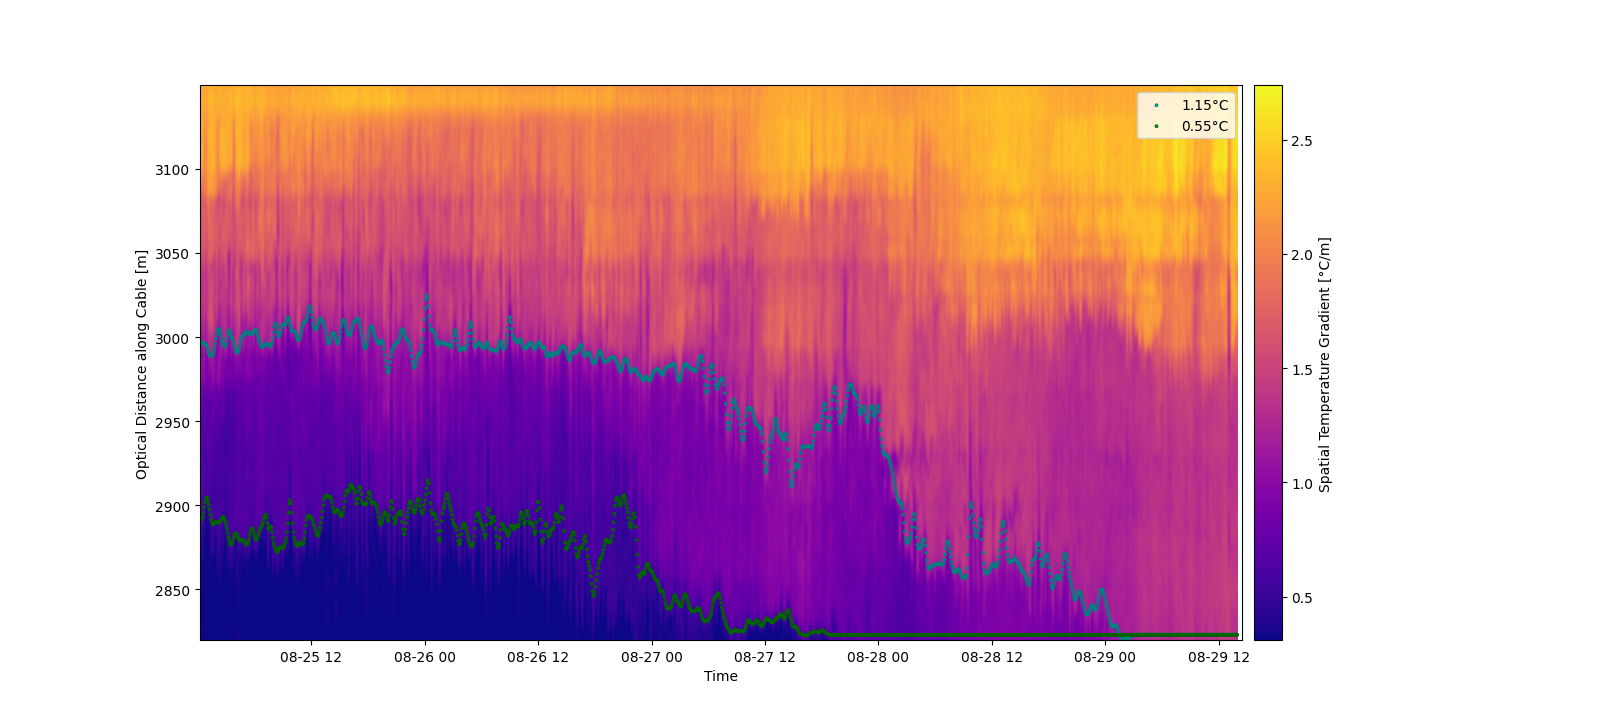

In [183]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
grad_arr = ps.SmoothedFiniteDifference(axis=1)._differentiate(filtered_arr_DTS, t=(plot_dists_zoomed_DTS[1] - plot_dists_zoomed_DTS[0]))
im1 = ax.imshow(filtered_arr_DTS.T, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed_DTS[0], plot_times_zoomed_DTS[-1],
                   plot_dists_zoomed_DTS[0], plot_dists_zoomed_DTS[-1]],
            cmap='plasma',
            vmin=np.percentile(filtered_arr_DTS[~np.isnan(filtered_arr_DTS)],1),
            vmax=np.percentile(filtered_arr_DTS[~np.isnan(filtered_arr_DTS)],99),
            )
ax.set_xlim([plot_times_DAS[0], plot_times_DAS[-1]])
ax.set_ylabel('Optical Distance along Cable [m]')
ax.set_xlabel('Time')
# for i in range(len(contour_points[contour_values[i]]['t'])):
#     for j in range(len(contour_points[contour_values[i]]['x'])):
#         nexttinds = 

colors = ['teal', 'darkgreen', 'black']
for i in range(len(contour_values)): plt.scatter(plot_times_zoomed_DTS, scipy.ndimage.gaussian_filter(contour_points_arr[i], 2), s=3, marker='o', facecolors='none', color=colors[i])
# plt.contour(plot_times_zoomed, plot_dists_zoomed, filtered_arr.T, contour_values)
# ax.axvline(x=plot_times[sliceind])
plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Spatial Temperature Gradient [°C/m]')
plt.show()

## Plotting

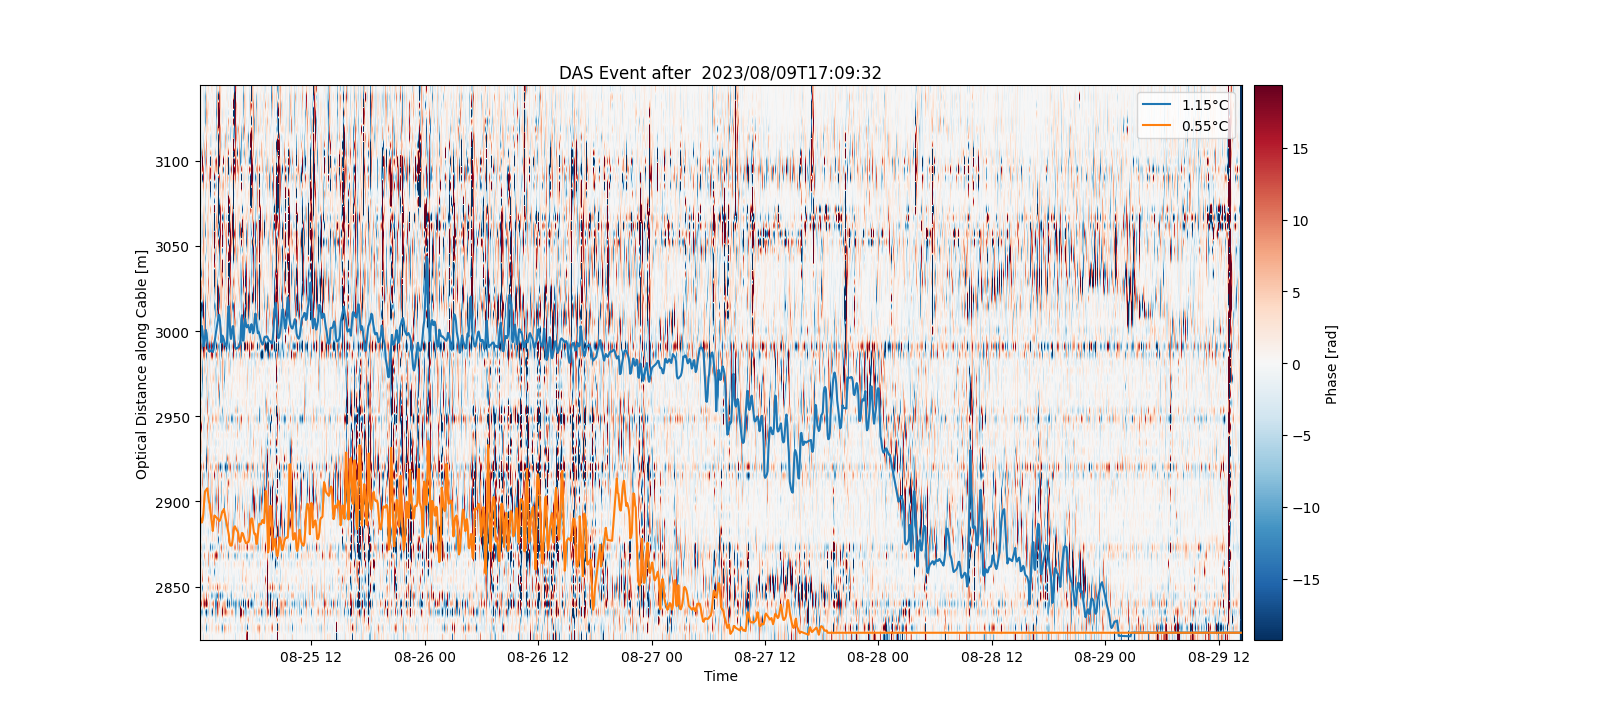

In [184]:
# Plot
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))

im = ax.imshow(plot_arr_DAS.T, aspect='auto',
             origin='lower',
             vmin=np.percentile(plot_arr_DAS[~np.isnan(plot_arr_DAS)],5),
             vmax=np.percentile(plot_arr_DAS[~np.isnan(plot_arr_DAS)],95),
             extent=[plot_times_DAS[0], plot_times_DAS[-1],
                  plot_dists_DAS[0], plot_dists_DAS[-1]],
             cmap='RdBu_r',
             # interpolation='none',
               zorder=0
             )

ax.set_ylabel('Optical Distance along Cable [m]')
ax.set_xlabel('Time')
ax.set_title('DAS Event after  {}'.format(plot_times[0].strftime("%Y/%m/%dT%H:%M:%S")))

for i in range(len(contour_values)): plt.plot(plot_times_DAS, contour_points_arr_DAS[i, :], '-')
# plt.contour(plot_times_zoomed_DTS, plot_dists_zoomed_DTS, filtered_arr_DTS.T, contour_values)
# ax.axvline(x=plot_times[sliceind])
plt.legend(contour_values_legend)


cbar = fig.colorbar(im, pad=0.01)
cbar.set_label('Phase [rad]')

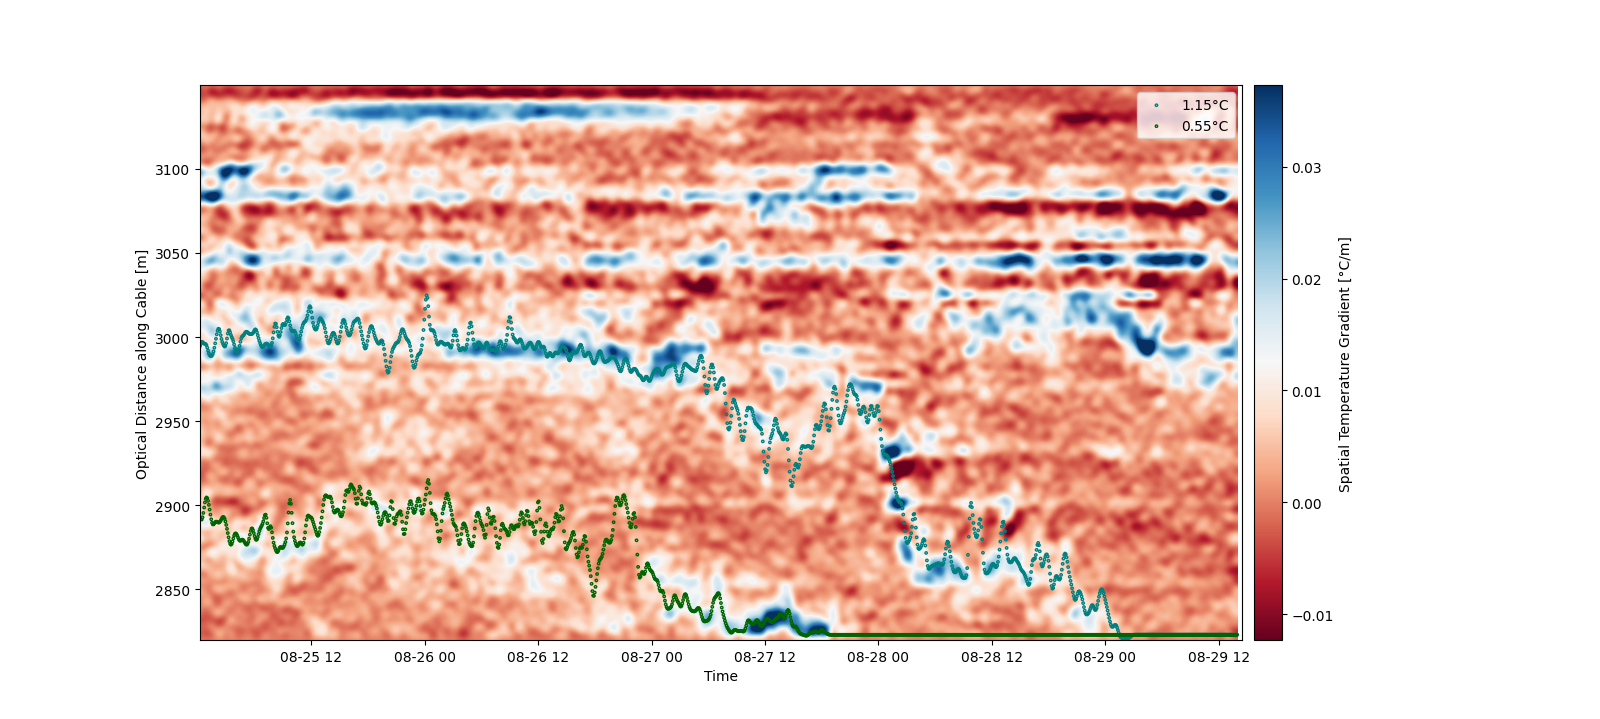

In [185]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
grad_arr = ps.SmoothedFiniteDifference(axis=1)._differentiate(filtered_arr_DTS, t=(plot_dists_zoomed_DTS[1] - plot_dists_zoomed_DTS[0]))
im1 = ax.imshow(scipy.ndimage.gaussian_filter(grad_arr.T, 5), origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed_DTS[0], plot_times_zoomed_DTS[-1],
                   plot_dists_zoomed_DTS[0], plot_dists_zoomed_DTS[-1]],
            cmap='RdBu',
            vmin=np.percentile(grad_arr[~np.isnan(grad_arr)],1),
            vmax=np.percentile(grad_arr[~np.isnan(grad_arr)],99),
            )
ax.set_ylabel('Optical Distance along Cable [m]')
ax.set_xlabel('Time')
ax.set_xlim([plot_times_DAS[0], plot_times_DAS[-1]])
# for i in range(len(contour_points[contour_values[i]]['t'])):
#     for j in range(len(contour_points[contour_values[i]]['x'])):
#         nexttinds = 

colors = ['teal', 'darkgreen', 'black']
for i in range(len(contour_values)): plt.scatter(plot_times_zoomed_DTS, scipy.ndimage.gaussian_filter(contour_points_arr[i], 2), s=3, marker='o', facecolors='none', color=colors[i])
# plt.contour(plot_times_zoomed_DTS, plot_dists_zoomed_DTS, filtered_arr_DTS.T, contour_values)
# ax.axvline(x=plot_times[sliceind])
plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Spatial Temperature Gradient [°C/m]')
plt.show()

## Plot the DAS spectrum along the contour

/var/folders/0w/3nhprhs523j29wbz2w1cnrl00000gn/T/ipykernel_98647/2679599648.py:31: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot((1/xf) * (1/60), scipy.ndimage.gaussian_filter(contour_spectrum, 1))
/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


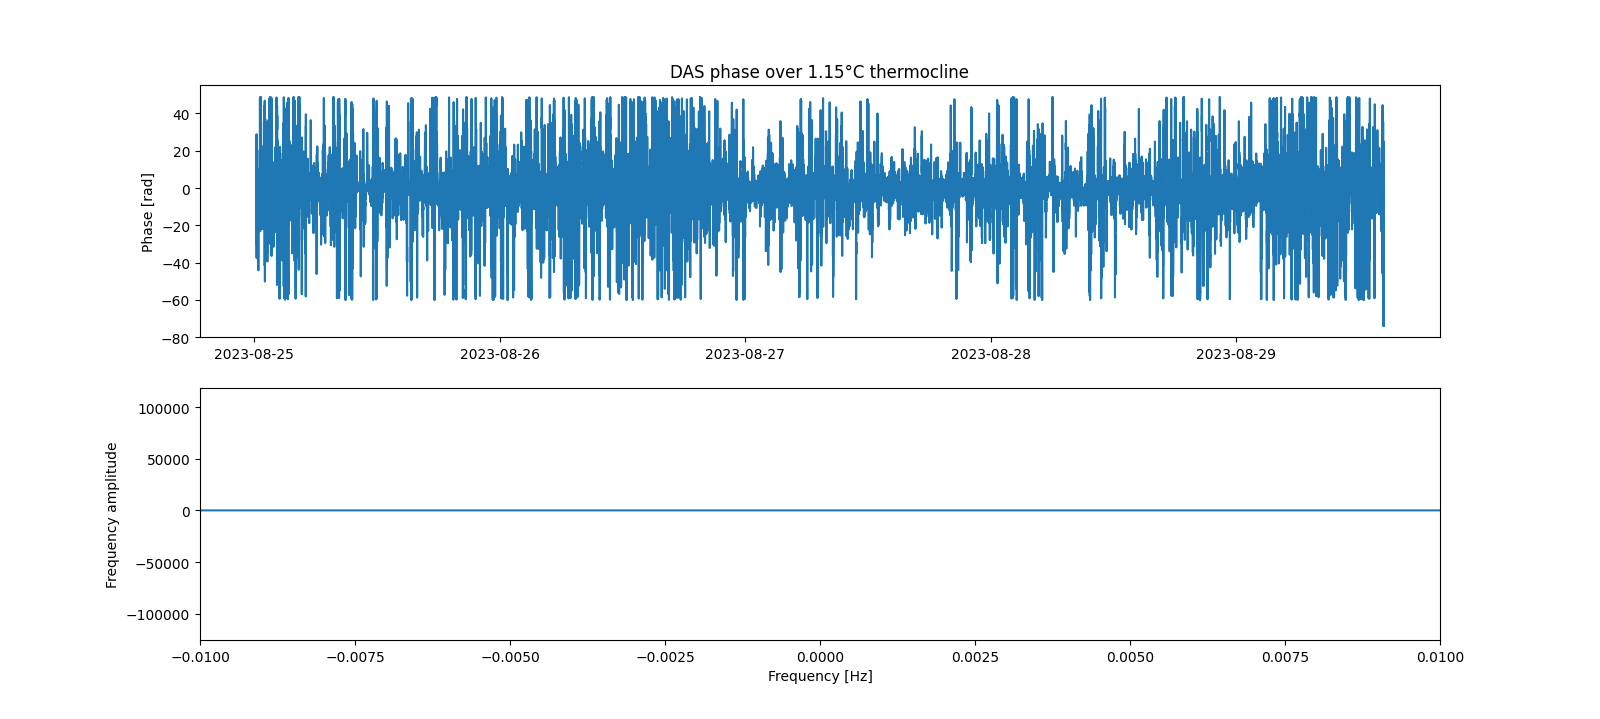

In [193]:
contour_ind = 0

interp = scipy.interpolate.RegularGridInterpolator((plot_times_DAS_int, plot_dists_DAS), plot_arr_DAS)
sample_points = np.array([plot_times_DAS_int, contour_points_arr_DAS[contour_ind, :]])
contour_DAS_values = interp(list(zip(plot_times_DAS_int, contour_points_arr_DAS[contour_ind, :])))
# Remove values greater than a value to prevent clipping errors
nan_inds = []
good_inds = []
lb = np.percentile(contour_DAS_values, 1)
ub = np.percentile(contour_DAS_values, 99)
for i in range(len(contour_DAS_values)):
    if (contour_DAS_values[i] >= lb) & (contour_DAS_values[i] <= ub):
        good_inds.append(i)
    else:
        contour_DAS_values[i] = float('NaN')
        nan_inds.append(i)
        
# Interpolate nan values
interp = scipy.interpolate.interp1d(good_inds, contour_DAS_values[good_inds], kind='slinear', fill_value='extrapolate')
contour_DAS_values[nan_inds] = interp(nan_inds) 

contour_spectrum = np.fft.fft(contour_DAS_values)
xf = np.fft.fftfreq(len(contour_DAS_values), 1)

fig, ax = plt.subplots(2, 1, figsize=(2.5*6.4,1.5*4.8))

ax[0].plot(plot_times_DAS, contour_DAS_values)
ax[0].set_ylabel("Phase [rad]")
ax[0].set_title("DAS phase over %s thermocline" % contour_values_legend[contour_ind])

ax[1].plot(xf, scipy.ndimage.gaussian_filter(contour_spectrum, 1))
ax[1].set_ylabel("Frequency amplitude")
ax[1].set_xlim([-0.01, 0.01])
ax[1].set_xlabel("Frequency [Hz]")
plt.show()
